In [ ]:
라이브러리 임포트

In [7]:
import numpy as np
import matplotlib.pyplot as pylab
from matplotlib import cm

from skimage import img_as_float, data
from skimage.data import astronaut
from skimage.io import imread
from skimage.color import rgb2gray, label2rgb, gray2rgb, rgba2rgb

from skimage.filters import sobel, threshold_otsu
from skimage.draw import circle_perimeter
from skimage.feature import canny
from skimage.transform import (hough_line, hough_line_peaks, \
                               hough_circle, hough_circle_peaks)
from skimage.segmentation import (felzenszwalb, slic, quickshift, \
                                  watershed, mark_boundaries, find_boundaries)

In [3]:
#영상 보기 함수
def plot_image(image, title, cmap='gray'):
    pylab.imshow(image, cmap=cm), pylab.title(title, size=20), pylab.axis('off')
    
def plot_ax_image(ax, image, title, cmap='gray', size = 20):
    ax.imshow(image, cmap=cmap)
    ax.set_title(title), ax.axis('off')

In [ ]:
능동 윤곽선(active contours)

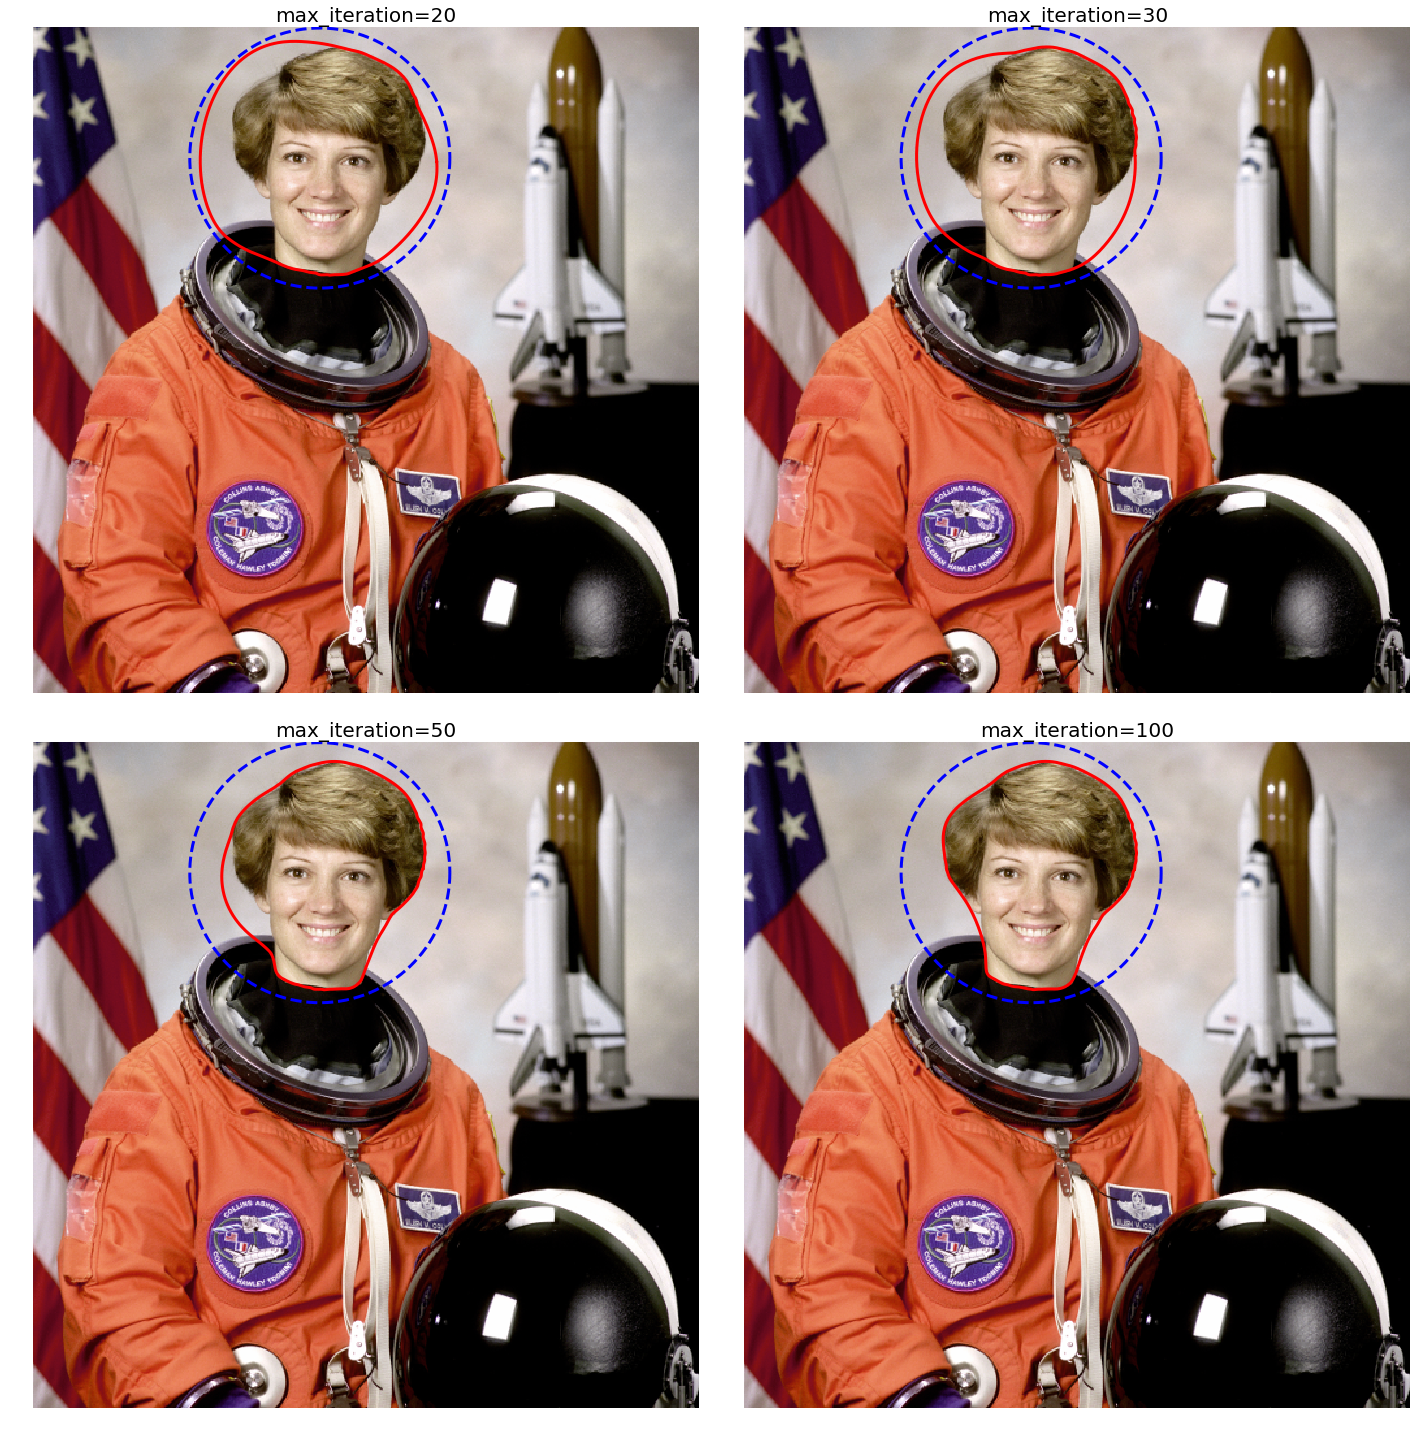

(None, None)

In [4]:
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

img = data.astronaut()
img_gray = rgb2gray(img)
s = np.linspace(0, 2* np.pi, 400)
x = 220 + 100*np.cos(s)
y = 100 + 100*np.sin(s)
init = np.array([x, y]).T

i = 1
pylab.figure(figsize=(20,20))
for max_it in [20, 30, 50, 100]:
    snake = active_contour(gaussian(img_gray, 3), init, alpha=0.015, beta=10, \
                           gamma=0.001, max_iterations=max_it)
    pylab.subplot(2,2,i), pylab.imshow(img)
    pylab.plot(init[:, 0], init[:, 1], '--b', lw=3)
    pylab.plot(snake[:, 0], snake[:, 1], '-r', lw=3)
    pylab.axis('off'), pylab.title('max_iteration=' + str(max_it), size=20)
    i += 1
    
pylab.tight_layout(), pylab.show()

In [ ]:
형태학적 스네이크(morphological snakes)

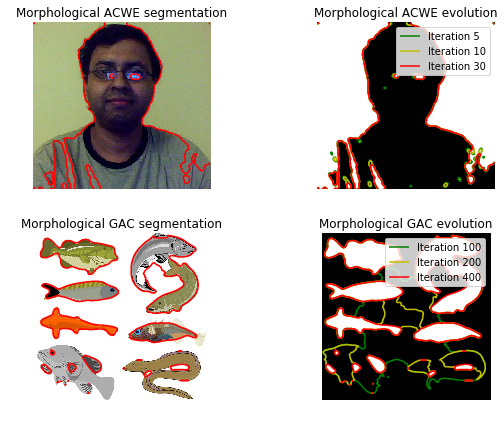

(None, None)

In [10]:
from skimage.segmentation import (morphological_chan_vese, \
                                  morphological_geodesic_active_contour, inverse_gaussian_gradient, \
                                  checkerboard_level_set)
def store_evolution_in(lst):
    """지정된 리스트에 레벨 세트의 진화를 저장하는 콜백 함수를 반환 """
    def _store(x):
        lst.append(np.copy(x))
        
    return _store
    
# 모폴로지 ACWE
image = imread('../images/me14.jpg')
image_gray = rgb2gray(image)
init_lvl_set = checkerboard_level_set(image_gray.shape, 6) # 초기 레벨 설정

evolution = [] # 진화를 그리기 위한 중간 결과 리스트
callback = store_evolution_in(evolution)
lvl_set = morphological_chan_vese(image_gray, 30, smoothing=3,\
                                  init_level_set=init_lvl_set, iter_callback=callback)

fig, axes = pylab.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
axes[0].imshow(image, cmap="gray"), axes[0].set_axis_off(),
axes[0].contour(lvl_set, [0.5], colors='r')
axes[0].set_title("Morphological ACWE segmentation", fontsize=12)
axes[1].imshow(lvl_set, cmap="gray"), axes[1].set_axis_off()

contour = axes[1].contour(evolution[5], [0.5], colors='g')
contour.collections[0].set_label("Iteration 5")
contour = axes[1].contour(evolution[10], [0.5], colors='y')
contour.collections[0].set_label("Iteration 10")
contour = axes[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration " + str(len(evolution)-1))
axes[1].legend(loc="upper right")
axes[1].set_title("Morphological ACWE evolution", fontsize=12)

# 모폴로지 GAC
image = imread('../images/fishes4.jpg')
image_gray = rgb2gray(image)
gimage = inverse_gaussian_gradient(image_gray)
init_lvl_set = np.zeros(image_gray.shape, dtype=np.int8) # 초기 레벨 설정
init_lvl_set[10:-10, 10:-10] = 1

evolution = [] # 진화를 그리기 위한 중간 결과 리스트
callback = store_evolution_in(evolution)
lvl_set = morphological_geodesic_active_contour(gimage, 400, init_lvl_set, \
smoothing=1, balloon=-1, threshold=0.7, iter_callback=callback)
axes[2].imshow(image, cmap="gray"), axes[2].set_axis_off()
axes[2].contour(lvl_set, [0.5], colors='r')
axes[2].set_title("Morphological GAC segmentation", fontsize=12)
axes[3].imshow(lvl_set, cmap="gray"), axes[3].set_axis_off()

contour = axes[3].contour(evolution[100], [0.5], colors='g')
contour.collections[0].set_label("Iteration 100")
contour = axes[3].contour(evolution[200], [0.5], colors='y')
contour.collections[0].set_label("Iteration 200")
contour = axes[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration " + str(len(evolution)-1))

axes[3].legend(loc="upper right")
axes[3].set_title("Morphological GAC evolution", fontsize=12)
fig.tight_layout(), pylab.show()

In [ ]:
OpenCV를 활용한 GrabCut

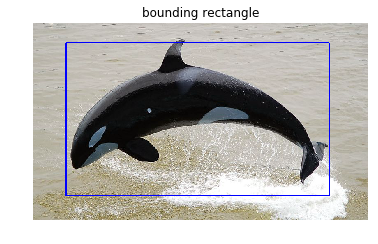

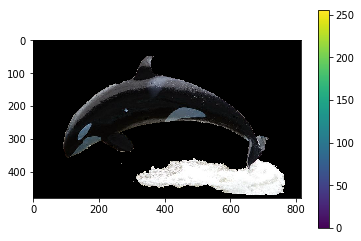

In [15]:
import cv2 # opencv 라이브러리 임포트

img = cv2.imread('../images/whale.jpg')
mask = np.zeros(img.shape[:2], np.uint8) # 마스크 영상 0으로 초기화
bg_model = np.zeros((1,65), np.float64)
fg_model = np.zeros((1,65), np.float64)
rect = (80, 50, 720, 420)

cv2.grabCut(img, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img2 = img*mask2[ : , : , np.newaxis]

cv2.rectangle(img, (rect[0],rect[1]), (rect[2],rect[3]), (0,0,255), 2 )
pylab.imshow(img), pylab.axis('off'), pylab.title('bounding rectangle')
pylab.show()
pylab.imshow(img2), pylab.colorbar()
pylab.show()

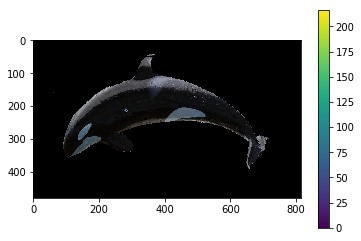

In [14]:
newmask = cv2.imread('../images/whale_mask.jpg')
# 녹색 표시(확실한 전경)된 위치 → 마스크 = 1로 변경
# 빨간색 표시(확실한 배경)된 위치 → 마스크 = 0으로 변경

mask = 2*np.ones(img.shape[:2], np.uint8) # 배경 화소 초기화
blue, green, red = cv2.split(newmask)
mask[(blue <= 20)&(green<= 20)&(red >= 200)]= 0 # 빨간 화소는 배경
mask[(blue <= 20)&(green>= 200)&(red <= 20)]= 1 # 녹색 화소는 전경

mask, bg_model, fg_model = \
    cv2.grabCut(img, mask, None, bg_model, fg_model, 5, cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask[:,:,np.newaxis]
pylab.imshow(img),pylab.colorbar()
pylab.show()